In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy
from scipy.spatial.distance import pdist, squareform
import sklearn
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
import requests
import time

In [2]:
def load_network_sparse(net_file,ngene):
    ppi_df = pd.read_csv(net_file,header=None,sep='\t')
    A = np.zeros((ngene,ngene))
    row_idx = ppi_df.iloc[:,0].values -1 
    col_idx = ppi_df.iloc[:,1].values -1
    A[row_idx, col_idx] = ppi_df.iloc[:,2].values
    assert (A == A.T).all()
    zero_rows = np.all(A == 0, axis=1)
    diag_indices = np.arange(ngene)
    A[diag_indices[zero_rows], diag_indices[zero_rows]] = 1
    return A

In [3]:
def load_all_nets(ppi_files,n_gene):
    '''
    parameters:
    - ppi_files: [str, str, ...], list of network file paths
    - ref_gene_file: str, file path, the file contains all genes, one gene per line
    output:
    - nets: n_file x n_gene x n_gene array with ppi networks
    '''
    n_file = len(ppi_files)
    nets = np.zeros((n_file,n_gene,n_gene))
    for i in range(n_file):
        A = load_network_sparse(ppi_files[i],n_gene)
        nets[i,:,:] = A
    return nets

In [4]:
def compute_rwr_original_sparse(ppi_files,restart_prob,ngene,nets):
    ''' 
    - ppi_files: list of network file paths
    - restart_prob: RWR restart probability
    - ngene: number of genes

    walks[i,:,:]: each column is the stationary distribution of a node
    '''
    n_file = len(ppi_files)
    e = np.ones(ngene)
    I = np.eye(ngene)
    walks = np.zeros((n_file,ngene,ngene))
    for i in range(n_file):
        A = nets[i,:,:]
        d = A @ e
        P = A / d # transition matrix
        W = (I - (1 - restart_prob) * P)
        W = np.linalg.inv(W)
        W = W * restart_prob 
        walks[i,:,:] = W
    return walks

In [5]:
# there are subtle differences between matlab implementation and python implementation.
# It's caused by after RWR, there are some values that are extremely small, 
# for example, in network 6, [1825,943], its value is 1e-17 ish, after taking log, the log becomes -38
# these differences accumulated and as a result, the eigenvalues become different.
# After filtering out the extreme numbers in matlab code, the two results become the same.
def svd_embed_sparse_func(walks, ngene, embed_dim):
    n_net = walks.shape[0]
    mat = np.zeros((ngene,ngene))
    W_updated = np.zeros_like(walks)
    for i in range(n_net):
        W = walks[i,:,:]
        W[W<=1e-8] = 0
        W = np.log(W, where = W > 1e-8)
        W_updated[i,:,:] = W
        tmp = W.T @ W
        mat = mat + tmp
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(mat,k=embed_dim)
    x = np.diag(np.sqrt(np.sqrt(eigenvalues))) @ eigenvectors.T
    return np.real(x)

In [ ]:
def load_train_test_anno(rand,fold,org,ont_type,ont_size1,ont_size2):
    '''
    - rand: 1 2 3 4 5
    - fold: 1 2 3 4 5
    - org: "Ecoli" or "yeast"
    '''
    file_name = 'data/train_test_split/'+org+'/rand' + str(rand) +'/fold' + str(fold) + '_' + ont_type+ '_' +  str(ont_size1)+ '_' +  str(ont_size2)+ '_train_anno.txt'
    train = pd.read_csv(file_name,header=None,sep = '\t')
    file_name = 'data/train_test_split/'+org+'/rand' + str(rand) +'/fold' + str(fold) + '_' + ont_type+ '_' +  str(ont_size1)+ '_' +  str(ont_size2)+ '_test_anno.txt'
    test = pd.read_csv(file_name,header=None,sep = '\t')
    return train.to_numpy(), test.to_numpy()

In [7]:
def augment_graph(nets, ngene, gene_clusters, mustlink_weight, cannotlink_weight):
    '''
    - nets: original adjacency matrices directly read from PPI files
    - gene_clusters: (num_clusers, num_genes), binary matrix indicating which gene belongs to which clusters
    '''
    n_nets = nets.shape[0]
    n_clusters = gene_clusters.shape[0]
    augmented = np.zeros((n_nets,(ngene+n_clusters),(ngene+n_clusters)))
    for i in range(n_nets):
        A = nets[i,:,:]
        A_block = np.block([[A,mustlink_weight*gene_clusters.T],[mustlink_weight*gene_clusters,cannotlink_weight*np.ones((n_clusters,n_clusters))]])
        np.fill_diagonal(A_block,0)
        zero_rows = np.all(np.absolute(A_block) == 0, axis=1)
        diag_indices = np.arange(ngene+n_clusters)
        A_block[diag_indices[zero_rows], diag_indices[zero_rows]] = 1
        augmented[i,:,:] = A_block
    return augmented

In [8]:
def augmented_RWR(augmented_nets, restart_prob):
    n_nets = augmented_nets.shape[0]
    n_nodes = augmented_nets.shape[1]
    augmented_walks = np.zeros((n_nets,n_nodes,n_nodes))
    e = np.ones(n_nodes)
    for i in range(n_nets):
        A = augmented_nets[i,:,:]
        d = np.absolute(A) @ e
        L = np.diag(d) - (1-restart_prob)*A
        L_inv = np.linalg.inv(L)
        W = restart_prob*(np.diag(d) @ L_inv)
        augmented_walks[i,:,:] = W
    return augmented_walks


In [9]:
def augmented_SVD_with_cannolink(aug_walks, embed_dim):
    n_net = aug_walks.shape[0]
    n_node = aug_walks.shape[1]
    mat = np.zeros((n_node,n_node))
    W_updated = np.zeros_like(aug_walks)
    for i in range(n_net):
        W = aug_walks[i,:,:]
        min_entry = W.min()
        if min_entry > 0:
            min_entry = 0.0
        W = W - min_entry
        W[W<=1e-8] = 0
        W = np.log(W, where = W > 1e-8)
        W_updated[i,:,:] = W
        tmp = W.T @ W
        mat = mat + tmp
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(mat,k=embed_dim)
    x = np.diag(np.sqrt(np.sqrt(eigenvalues))) @ eigenvectors.T
    return np.real(x)

In [10]:
def get_knn_ind(embed,train_anno):
    '''
    parameters:
    - embed: (dim, num_gene), protein embeddings
    - train_anno: annotations for training proteins
    output:
    dist_mat: n_gene x n_gene
    sorted_ind: ngene x (ngene-1), top n labels
    '''
    n_gene = train_anno.shape[1]
    train_idx = np.where(sum(train_anno)>0)[0]
    # embed = embed[:n_gene,:n_gene]
    dist_mat = squareform(pdist(embed.T))
    dist_mat = dist_mat[:n_gene,:n_gene] # symmetrical
    np.fill_diagonal(dist_mat, 1e8)
    # mask = np.ones(n_gene, dtype=bool)
    # mask[train_idx] = False
    # dist_mat[:, mask] = 1e8

    sorted_ind = np.argsort(dist_mat, axis=1)
    # sorted_ind = sorted_ind[:,1:] # each row, gene's nearest neighbors
    
    return dist_mat, sorted_ind


In [11]:
def majority_vote(dist_mat, knn_mat, train_anno, test_anno,k, weighted=True):
    '''
    parameters:
    - dist_mat: n_gene x n_gene
    - knn_mat: ngene x (ngene-1), sorted labels
    - train_anno: n_label x n_gene
    - test_anno: n_label x n_gene
    - k: number of nearest neighbors
    - weighted: boolean, whether doing weighted majority vote or not
    output:
    - final_scores: n_label x n_test, normalized scores of each label
    - num_voters: vector of numbers of voting nodes
    '''
    train_idx = np.where(sum(train_anno)>0)[0]
    test_idx = np.where(sum(test_anno)>0)[0]
    final_scores = np.zeros((train_anno.shape[0],len(test_idx)))
    num_voters = []
    updated_voters = []
    c = 0
    for index, i in enumerate(test_idx):
        nn = knn_mat[i,:k]
        nn_labeled = nn[np.isin(nn, train_idx)] 
        # num_voters.append(len(nn_labeled))
        if len(nn_labeled) == 0: # if within the first k neighbors, no neighbor is labeled, then use the nearest neighbor with label
            voting_node = knn_mat[i,:][np.isin(knn_mat[i,:], train_idx)][0]
            scores = np.array(train_anno[:,voting_node])
            scores = scores / sum(scores)
            num_voters.append(len(nn_labeled))
            tmp = [voting_node]
            updated_voters.append(tmp)
        else:
            votes = np.array(train_anno[:,nn_labeled])
            if weighted:
                d = dist_mat[i,nn_labeled]
                # print(d)
                d = d[np.nonzero(d)]
                # print(d)
                votes = np.array(train_anno[:,nn_labeled[np.nonzero(d)]])
                tmp = nn_labeled[np.nonzero(d)]
                updated_voters.append(tmp)
                num_voters.append(len(d))
                if len(d) == 0:
                    c += 1
                    voting_node = np.random.choice(train_idx)
                    scores = np.array(train_anno[:,voting_node])
                    scores = scores / sum(scores)
                else:
                    weights = 1 / d
                    # print(weights.shape)
                    scores = votes @ weights.T
                    scores = scores / sum(scores)
                    # print(scores.shape)
            else:
                num_voters.append(len(nn_labeled))
                updated_voters.append(nn_labeled)
                scores = np.sum(votes,axis=1)
                scores = scores / sum(scores)
        
        final_scores[:,index] = np.squeeze(scores)
    print(c)
    return final_scores, num_voters,updated_voters


In [12]:
def acc_top1_pred(test_scores, test_anno):
    '''
    for each test gene, find the label with the highest predicted score, use it as the predicted label
    accuracy is defined as (#predicted label in test true labels) / (#test genes)
    problems: if there's a tie, the one with smaller index will be used
    parameters:
    - test_scores: n_label x n_test
    - test_anno: n_label x n_gene
    output:
    - acc: accuracy score
    '''
    test_idx = np.where(sum(test_anno)>0)[0]
    zero_idx = np.where(np.sum(test_scores,axis=0)==0)[0]
    mask = np.ones(len(test_idx), dtype=bool)
    mask[zero_idx] = False
    test_anno = test_anno[:,test_idx] # n_label x n_test
    sorted_index = np.argsort(-1*test_scores,axis=0) # n_label x n_test, with row 0 the highest predicted label for each gene
    true_pred = test_anno[sorted_index[0,:], np.arange(test_anno.shape[1])]
    true_pred = true_pred[mask]
    print(len(zero_idx))
    acc = np.mean(true_pred)
    return acc,true_pred
    

In [13]:
def f1_auprc_pred(test_scores, test_anno,top_n):
    '''
    for each test gene, find the labels with the top_n highest predicted scores, use them as the predicted labels
    f1 is defined as 2*TP / 2*TP + FP + FN
    probelms: if there's a tie, the one with smaller index will be used, only top n predictions will be considered, it will increase the number of FN
    parameters:
    - test_scores: n_label x n_test
    - test_anno: n_label x n_gene
    - top_n: int, the number of labels to be predicted
    output:
    - acc: accuracy score
    '''
    test_idx = np.where(sum(test_anno)>0)[0]
    zero_idx = np.where(np.sum(test_scores,axis=0)==0)[0]

    mask = np.ones(len(test_idx), dtype=bool)
    mask[zero_idx] = False
    test_anno = test_anno[:,test_idx] # n_label x n_test
    
    test_anno = test_anno[:,mask]
    test_scores = test_scores[:,mask]
    sorted_index = np.argsort(-1*test_scores,axis=0) # n_label x n_test, with row 0 the highest predicted label for each gene
    top_ind = sorted_index[:top_n,:].flatten()
    pred = np.zeros_like(test_anno)
    cols = np.tile(np.arange(test_anno.shape[1]), top_n)
    pred[top_ind, cols] = 1
    # print(pred)
    f1 = sklearn.metrics.f1_score(test_anno.flatten(),pred.flatten())
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(test_anno.flatten(), pred.flatten())
    auprc = sklearn.metrics.auc(recall, precision)
    return f1, auprc
    


In [14]:
'''
for each augmented node, randomly choose a fixed number of nodes to connect to
the number of genes that each augmented node connects to are the same except for the last one
'''
def random_split_vector(train_anno,n_gene, num_sub_vectors,seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    input_vector = np.where(sum(train_anno)>0)[0]
    # input_vector = np.arange(n_gene)
    
    if num_sub_vectors <= 0 or num_sub_vectors > len(input_vector):
        raise ValueError("Invalid number of sub-vectors")
    
    shuffled_vector = np.random.permutation(input_vector)
    sub_vector_size = len(shuffled_vector) // num_sub_vectors
    
    group_matrix = np.zeros((num_sub_vectors, len(input_vector)), dtype=int)
    res_matrix = np.zeros((num_sub_vectors, n_gene), dtype=int)
    
    start_index = 0
    for i in range(num_sub_vectors):
        end_index = start_index + sub_vector_size
        
        if i == num_sub_vectors - 1:
            end_index = len(shuffled_vector)
        
        selected_indices = shuffled_vector[start_index:end_index]
        
        group_matrix[i, np.isin(shuffled_vector, selected_indices)] = 1
        # res_matrix[i, selected_indices] = 1
        
        start_index = end_index
    
    res_matrix[:,shuffled_vector] = group_matrix
    
    return res_matrix

In [15]:
'''
for each gene, random choose from 1 augment node to add an edge to
for each augmented node, the number of genes that it connects to are at random
'''
def generate_random_gene_cluster(train_anno, n_cluster, n_gene, seed=None):
    '''
    return:
    - rand_cluster: (num_cluster, num_gene), according to annotation_mat, each gene will be assigned to a cluster if it has an annotation that belongs to the cluster
    '''
    if seed is not None:
        np.random.seed(seed)
    train_idx = np.where(sum(train_anno)>0)[0]
    rand_cluster = np. zeros((n_cluster,n_gene))
    row_indices = np.random.randint(0, n_cluster, size=n_gene)
    col_indices = np.arange(n_gene)
    rand_cluster[row_indices, col_indices] = 1
    rand_cluster[:, ~train_idx] = 0
    return rand_cluster


In [16]:
'''
for each augmented node, randomly choose a fixed number of nodes to connect to
the number of genes that each augmented node connects to are the same except for the last one
'''
def aug_to_all(n_gene, num_sub_vectors,seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # input_vector = np.where(sum(train_anno)>0)[0]
    input_vector = np.arange(n_gene)
    
    if num_sub_vectors <= 0 or num_sub_vectors > len(input_vector):
        raise ValueError("Invalid number of sub-vectors")
    
    shuffled_vector = np.random.permutation(input_vector)
    sub_vector_size = len(shuffled_vector) // num_sub_vectors
    
    group_matrix = np.zeros((num_sub_vectors, len(input_vector)), dtype=int)
    res_matrix = np.zeros((num_sub_vectors, n_gene), dtype=int)
    
    start_index = 0
    for i in range(num_sub_vectors):
        end_index = start_index + sub_vector_size
        
        if i == num_sub_vectors - 1:
            end_index = len(shuffled_vector)
        
        selected_indices = shuffled_vector[start_index:end_index]
        
        group_matrix[i, np.isin(shuffled_vector, selected_indices)] = 1
        # res_matrix[i, selected_indices] = 1
        
        start_index = end_index
    
    res_matrix[:,shuffled_vector] = group_matrix
    
    return res_matrix

In [17]:
def run_pipeline(ppi_files,n_gene,method=None,restart_prob=None,embed_dim=None,rand=None,org=None,n_fold=None,k=None,ont_type=None,ont_size1=None,ont_size2=None,n_cluster=None):
    ''' 
    parameters:
    - ppi_files: list of str, list of file paths to ppi networks
    - n_gene: int, number of genes
    - method: list of str, one or more of Mashup, REPEL, deepNF, BIONIC
    - restart_prob: float, RWR restart probability
    - embed_dim: int, number of dimension
    - rand: int, random split
    - org: str, "yeast" or "Ecoli" or "human"
    - n_fold: int, total number of folds
    - k: int, number of nearest neighbors to be considered
    - ont_type: str, bp or mf or cc
    - ont_size1: int, 11, 31, 101
    - ont_size2: int, 30, 100, 300
    - n_cluster: int, number of random augmented nodes
    output:
    - performance_dict: a dictionary contains list of performances for all methods
    '''

    performance_dict = {}

    for m in method:
        m_acc = m + "_acc"
        m_f1 = m + "_f1"
        m_auprc = m + "_auprc"
        performance_dict[m_acc] = []
        performance_dict[m_f1] = []
        performance_dict[m_auprc] = []
        for i in range(n_fold):
            print("fold: ", i+1)
            train_anno, test_anno = load_train_test_anno(rand,i+1,org,ont_type,ont_size1,ont_size2)
            if m == "Mashup":
                print("Mashup")
                nets = load_all_nets(ppi_files,n_gene)
                walks = compute_rwr_original_sparse(ppi_files,restart_prob,n_gene,nets)
                x = svd_embed_sparse_func(walks, n_gene, embed_dim)
                dist_mat, knn = get_knn_ind(x,train_anno)
                scores, _, _ = majority_vote(dist_mat, knn, train_anno, test_anno,k)
                acc,_ = acc_top1_pred(scores, test_anno)
                f1, auprc = f1_auprc_pred(scores, test_anno,3)
                performance_dict[m_acc].append(acc)
                performance_dict[m_f1].append(f1)
                performance_dict[m_auprc].append(auprc)
            elif m == "REPEL":
                print("Random Augmentation, strict degrees")
                nets = load_all_nets(ppi_files,n_gene)
                rand_cluster = random_split_vector(train_anno,n_gene, n_cluster,seed=None)
                rand_graph = augment_graph(nets, n_gene, rand_cluster, 1, -1)
                rand_rwr_res = augmented_RWR(rand_graph, restart_prob)
                mat_rand_x = augmented_SVD_with_cannolink(rand_rwr_res, embed_dim)
                dist_mat, knn = get_knn_ind(mat_rand_x,train_anno)
                scores, _,_ = majority_vote(dist_mat, knn, train_anno, test_anno,k, weighted=True)
                acc,_ = acc_top1_pred(scores, test_anno)
                f1, auprc = f1_auprc_pred(scores, test_anno,3)
                performance_dict[m_acc].append(acc)
                performance_dict[m_f1].append(f1)
                performance_dict[m_auprc].append(auprc)
            # elif m == "RandAug_flex":
            #     print("Random Augmentation, flexible degrees")
            #     nets = load_all_nets(ppi_files,n_gene)
            #     rand_cluster = generate_random_gene_cluster(train_anno, n_cluster, n_gene)
            #     rand_graph = augment_graph(nets, n_gene, rand_cluster, 1, -1)
            #     rand_rwr_res = augmented_RWR(rand_graph, restart_prob)
            #     mat_rand_x = augmented_SVD_with_cannolink(rand_rwr_res, embed_dim)
            #     dist_mat, knn = get_knn_ind(mat_rand_x,train_anno)
            #     scores, _,_ = majority_vote(dist_mat, knn, train_anno, test_anno,k, weighted=True)
            #     acc,_ = acc_top1_pred(scores, test_anno)
            #     f1, auprc = f1_auprc_pred(scores, test_anno,3)
            #     performance_dict[m_acc].append(acc)
            #     performance_dict[m_f1].append(f1)
            #     performance_dict[m_auprc].append(auprc)
            elif m == "deepNF":
                print("deepNF")
                
            elif m == "BIONIC":
                print()
            else:
                print("Haven't implemented yet")
                return
    return performance_dict


In [18]:
def write_log(performance_dict,rand,org,ont_type,ont_size1,ont_size2,save_path=None):
    with open(save_path,"a") as f:
        tmp = org + " " + "rand " + str(rand) + " " + ont_type + " " + str(ont_size1) + " " + str(ont_size2) 
        f.write(tmp)
        f.write("\n")
        for k, v in performance_dict.items():
            f.write(k)
            f.write(" ")
            for i in v:
                f.write(f"{i:.4f}")
                f.write(" ")
            f.write("\n")

In [19]:
# for yeast
string_nets = ['neighborhood', 'fusion', 'cooccurence', 'coexpression', 'experimental', 'database']
ppi_files = []
for net in string_nets:
    tmp = 'data/networks/yeast/yeast_string_'+net+'_adjacency.txt'
    ppi_files.append(tmp)

all_genes = pd.read_csv("data/annotations/yeast/go_yeast_ref_genes.txt",header=None)
all_genes = list(all_genes.iloc[:,0].values)
n_gene = len(all_genes)
print(ppi_files)
print(n_gene)

['data/networks/yeast/yeast_string_neighborhood_adjacency.txt', 'data/networks/yeast/yeast_string_fusion_adjacency.txt', 'data/networks/yeast/yeast_string_cooccurence_adjacency.txt', 'data/networks/yeast/yeast_string_coexpression_adjacency.txt', 'data/networks/yeast/yeast_string_experimental_adjacency.txt', 'data/networks/yeast/yeast_string_database_adjacency.txt']
6400


In [ ]:
method=['REPEL']
restart_prob=0.5
embed_dim=400
org="yeast"
n_fold=5
k=10
n_clust_list = [2,5,10,15,20,30,40,60]
ont_type_list=["bp","mf","cc"]
ont_size1_list=[11,31,101]
ont_size2_list=[30,100,300]
# n_cluster=20
for rand in range(1,6):
    print("rand: ",rand)
    for n_cluster in n_clust_list:
        print("cluster: ",n_cluster)
        for ont_type in ont_type_list:
            print("ont_type")
            for c in range(3):
                ont_size1 = ont_size1_list[c]
                ont_size2 = ont_size2_list[c]
                performance_dict = run_pipeline(ppi_files,n_gene,method=method,restart_prob=restart_prob,embed_dim=embed_dim,rand=rand,org=org,n_fold=n_fold,k=k,ont_type=ont_type,ont_size1=ont_size1,ont_size2=ont_size2,n_cluster=n_cluster)
                write_log(performance_dict,rand,org,ont_type,ont_size1,ont_size2,n_cluster,save_path="yeast_result_log_clust_rerun.txt")


rand:  1
cluster:  2
ont_type
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees
0
0
fold:  5
Random Augmentation, strict degrees
0
0
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees
0
0
fold:  5
Random Augmentation, strict degrees
0
0
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees
0
0
fold:  5
Random Augmentation, strict degrees
0
0
ont_type
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees
0
0
fold:  5
Random Augmentation, 

KeyboardInterrupt: 

In [158]:
nets = load_all_nets(ppi_files,n_gene)
walks = compute_rwr_original_sparse(ppi_files,0.5,n_gene,nets)


In [159]:
n_net = walks.shape[0]
mat = np.zeros((6400,6400))
W_updated = np.zeros_like(walks)
for i in range(n_net):
    W = walks[i,:,:]
    W[W<=1e-8] = 0
    W = np.log(W, where = W > 1e-8)
    W_updated[i,:,:] = W
    tmp = W.T @ W
    mat = mat + tmp
mu_eigenvalues, mu_eigenvectors = scipy.sparse.linalg.eigs(mat,k=400)
mu_x = np.diag(np.sqrt(np.sqrt(mu_eigenvalues))) @ mu_eigenvectors.T


In [160]:
mu_eigenvalues

array([1.03569295e+10+0.j, 4.67723103e+08+0.j, 3.09937254e+08+0.j,
       2.87039938e+08+0.j, 7.64088787e+07+0.j, 4.61697519e+07+0.j,
       3.12264984e+07+0.j, 2.50183729e+07+0.j, 1.90563126e+07+0.j,
       1.75010456e+07+0.j, 1.33666219e+07+0.j, 1.16361297e+07+0.j,
       1.10877468e+07+0.j, 9.98114167e+06+0.j, 8.11696134e+06+0.j,
       7.72262291e+06+0.j, 7.29356352e+06+0.j, 7.00058705e+06+0.j,
       6.15905757e+06+0.j, 5.67407654e+06+0.j, 5.30037323e+06+0.j,
       4.79283663e+06+0.j, 4.72375627e+06+0.j, 4.42665659e+06+0.j,
       4.15978494e+06+0.j, 4.11046024e+06+0.j, 3.86460795e+06+0.j,
       3.47124250e+06+0.j, 3.42861213e+06+0.j, 3.13559815e+06+0.j,
       2.99756289e+06+0.j, 2.82548095e+06+0.j, 2.73933579e+06+0.j,
       2.61371827e+06+0.j, 2.52467087e+06+0.j, 2.44080135e+06+0.j,
       2.32514524e+06+0.j, 2.22696660e+06+0.j, 2.10928213e+06+0.j,
       2.00835793e+06+0.j, 1.96776684e+06+0.j, 1.93294133e+06+0.j,
       1.91819152e+06+0.j, 1.88967366e+06+0.j, 1.82285932e+06+

/Users/d/miniforge3/envs/networks/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/d/miniforge3/envs/networks/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


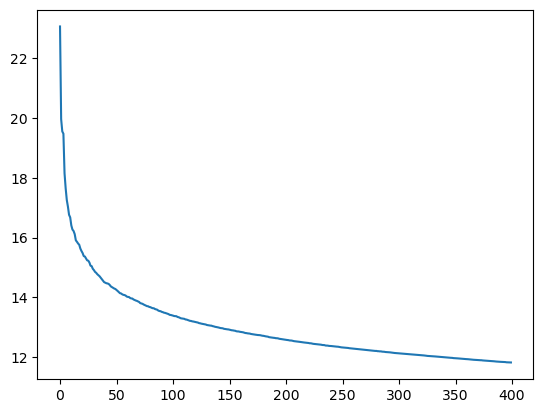

In [161]:
plt.plot(np.log(mu_eigenvalues))

In [162]:
train_anno, test_anno = load_train_test_anno(1,1,"yeast","cc",11,30)

In [163]:
nets = load_all_nets(ppi_files,n_gene)
rand_cluster = random_split_vector(train_anno,n_gene, 16,seed=None)
rand_graph = augment_graph(nets, n_gene, rand_cluster, 1, -1)
rand_rwr_res = augmented_RWR(rand_graph, 0.5)
# mat_rand_x = augmented_SVD_with_cannolink(rand_rwr_res, 400)

In [165]:
aug_walks = rand_rwr_res
n_net = aug_walks.shape[0]
n_node = aug_walks.shape[1]
mat = np.zeros((n_node,n_node))
W_updated = np.zeros_like(aug_walks)
for i in range(n_net):
    W = aug_walks[i,:,:]
    min_entry = W.min()
    if min_entry > 0:
        min_entry = 0.0
    W = W - min_entry
    W[W<=1e-8] = 0
    W = np.log(W, where = W > 1e-8)
    W_updated[i,:,:] = W
    tmp = W.T @ W
    mat = mat + tmp
r_eigenvalues, r_eigenvectors = scipy.sparse.linalg.eigs(mat[:6400,:6400],k=400)
r_x = np.diag(np.sqrt(np.sqrt(r_eigenvalues))) @ r_eigenvectors.T


In [166]:
r_eigenvalues

array([7.73098485e+09+0.j, 3.30060225e+04+0.j, 2.25549503e+04+0.j,
       1.60093741e+04+0.j, 1.43477672e+04+0.j, 1.27478124e+04+0.j,
       1.13092694e+04+0.j, 1.01913379e+04+0.j, 9.60558189e+03+0.j,
       9.37578759e+03+0.j, 9.10075897e+03+0.j, 9.02263716e+03+0.j,
       8.90941884e+03+0.j, 8.85839131e+03+0.j, 8.75107015e+03+0.j,
       8.69711323e+03+0.j, 8.64464978e+03+0.j, 8.50831713e+03+0.j,
       8.44070802e+03+0.j, 8.39932772e+03+0.j, 8.21146505e+03+0.j,
       8.06033870e+03+0.j, 7.96456258e+03+0.j, 7.85056525e+03+0.j,
       7.33579512e+03+0.j, 7.07389061e+03+0.j, 6.82641061e+03+0.j,
       6.29689486e+03+0.j, 6.18583019e+03+0.j, 5.84899997e+03+0.j,
       5.72205809e+03+0.j, 5.41764899e+03+0.j, 5.22957387e+03+0.j,
       5.05388269e+03+0.j, 4.92343992e+03+0.j, 4.71646979e+03+0.j,
       4.63858457e+03+0.j, 4.53851843e+03+0.j, 4.50809337e+03+0.j,
       4.36785574e+03+0.j, 4.29167930e+03+0.j, 4.19176776e+03+0.j,
       4.13531555e+03+0.j, 4.04746410e+03+0.j, 3.90728891e+03+

/Users/d/miniforge3/envs/networks/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/d/miniforge3/envs/networks/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


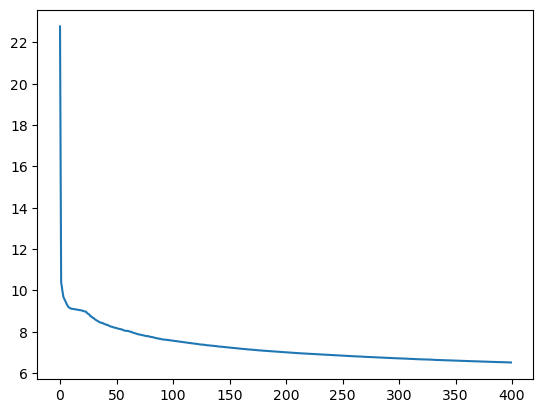

In [167]:
plt.plot(np.log(r_eigenvalues))

In [ ]:
method=['MashUp','REPEL']
restart_prob=0.5
embed_dim=400
org="yeast"
n_fold=5
k=10
ont_type_list=["bp","mf","cc"]
ont_size1_list=[11,31,101]
ont_size2_list=[30,100,300]
n_cluster=20
for rand in range(1,6):
    print("rand: ",rand)
    for ont_type in ont_type_list:
        print("ont_type")
        for c in range(3):
            ont_size1 = ont_size1_list[c]
            ont_size2 = ont_size2_list[c]
            performance_dict = run_pipeline(ppi_files,n_gene,method=method,restart_prob=restart_prob,embed_dim=embed_dim,rand=rand,org=org,n_fold=n_fold,k=k,ont_type=ont_type,ont_size1=ont_size1,ont_size2=ont_size2,n_cluster=n_cluster)
            write_log(performance_dict,rand,org,ont_type,ont_size1,ont_size2,save_path="yeast_result_log.txt")



rand:  1
ont_type
fold:  1
Mashup
0
0
fold:  2
Mashup
0
0
fold:  3
Mashup
0
0
fold:  4
Mashup
0
0
fold:  5
Mashup
0
0
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees
0
0
fold:  5
Random Augmentation, strict degrees
0
0
fold:  1
Random Augmentation, flexible degrees
0
0
fold:  2
Random Augmentation, flexible degrees
0
0
fold:  3
Random Augmentation, flexible degrees
0
0
fold:  4
Random Augmentation, flexible degrees
0
0
fold:  5
Random Augmentation, flexible degrees
0
0
fold:  1
Mashup
0
0
fold:  2
Mashup
0
0
fold:  3
Mashup
1
0
fold:  4
Mashup
0
0
fold:  5
Mashup
0
0
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees
0
0
fold:  5
Random Augmentation, strict degrees
0
0
fold:  1
Random Augmentation, flexibl

In [19]:
# for E.coli
string_nets = ['neighborhood', 'fusion', 'cooccurence', 'coexpression', 'experimental', 'database']
ppi_files = []
for net in string_nets:
    tmp = 'data/networks/Ecoli/ecoli_string_'+net+'_adjacency.txt'
    ppi_files.append(tmp)

all_genes = pd.read_csv("data/annotations/Ecoli/ecoli_ref_genes.txt",header=None,sep='\t')
all_genes = list(all_genes.iloc[:,1].values)
n_gene = len(all_genes)
print(ppi_files)
print(n_gene)


['data/networks/Ecoli/ecoli_string_neighborhood_adjacency.txt', 'data/networks/Ecoli/ecoli_string_fusion_adjacency.txt', 'data/networks/Ecoli/ecoli_string_cooccurence_adjacency.txt', 'data/networks/Ecoli/ecoli_string_coexpression_adjacency.txt', 'data/networks/Ecoli/ecoli_string_experimental_adjacency.txt', 'data/networks/Ecoli/ecoli_string_database_adjacency.txt']
4140


In [25]:
method=['Mashup','REPEL']
restart_prob=0.5
embed_dim=400
org="Ecoli"
n_fold=5
k=10
ont_type_list=["bp","mf","cc"]
ont_size1_list=[11,31,101]
ont_size2_list=[30,100,300]
n_cluster=10
for rand in range(1,6):
    print("rand: ",rand)
    for ont_type in ont_type_list:
        print("ont_type")
        for c in range(3):
            ont_size1 = ont_size1_list[c]
            ont_size2 = ont_size2_list[c]
            performance_dict = run_pipeline(ppi_files,n_gene,method=method,restart_prob=restart_prob,embed_dim=embed_dim,rand=rand,org=org,n_fold=n_fold,k=k,ont_type=ont_type,ont_size1=ont_size1,ont_size2=ont_size2,n_cluster=n_cluster)
            write_log(performance_dict,rand,org,ont_type,ont_size1,ont_size2,save_path="Ecoli_result_log_rerun.txt")



rand:  1
ont_type
fold:  1
Mashup
0
0
fold:  2
Mashup
0
0
fold:  3
Mashup
0
0
fold:  4
Mashup
0
0
fold:  5
Mashup
0
0
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees
0
0
fold:  5
Random Augmentation, strict degrees
0
0
fold:  1
Mashup
0
0
fold:  2
Mashup
0
0
fold:  3
Mashup
0
0
fold:  4
Mashup
0
0
fold:  5
Mashup
0
0
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees
0
0
fold:  5
Random Augmentation, strict degrees
0
0
fold:  1
Mashup
1
0
fold:  2
Mashup
1
0
fold:  3
Mashup
0
0
fold:  4
Mashup
0
0
fold:  5
Mashup
0
0
fold:  1
Random Augmentation, strict degrees
0
0
fold:  2
Random Augmentation, strict degrees
0
0
fold:  3
Random Augmentation, strict degrees
0
0
fold:  4
Random Augmentation, strict degrees


In [28]:
bionic_embedding_yeast = pd.read_csv("bionic/outputs/yeast_mu_features.tsv",sep="\t",header=0,index_col=0)

In [57]:
bionic_embedding_yeast

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
3,0.050537,0.003271,-0.007795,-0.007173,0.009738,0.036700,0.109055,0.039776,-0.000476,-0.053741,...,0.063442,0.046854,-0.001912,-0.032952,0.050103,0.023812,0.027381,-0.000360,-0.017686,0.027831
4,-0.002273,-0.017790,0.034701,0.014156,-0.002033,-0.026952,0.009565,0.016115,0.011832,0.002813,...,-0.026655,0.000888,0.019763,0.001680,-0.034513,0.024662,-0.039881,-0.011932,-0.019781,0.019160
5,-0.023527,-0.003914,0.041334,-0.000501,0.014142,-0.002492,0.005474,0.008997,-0.002058,0.004952,...,-0.046948,0.013144,0.024012,-0.041107,-0.045504,-0.001003,-0.017647,0.026132,-0.020047,0.009606
6,-0.023002,0.027390,-0.013688,-0.036173,0.010014,0.034546,-0.001970,0.012318,-0.024160,-0.005908,...,-0.025908,-0.006696,0.010555,-0.014571,-0.023203,-0.006785,-0.007830,0.010389,0.006674,-0.017783
7,-0.011708,-0.019416,0.032647,0.008173,0.002148,-0.009117,0.000661,0.019966,0.011098,0.008675,...,-0.041883,-0.012149,0.008531,0.000419,-0.014533,0.011269,-0.024946,0.020191,-0.010333,0.029921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6396,-0.010729,0.006673,0.008599,-0.007139,0.000313,-0.000269,-0.001735,-0.005525,-0.006464,0.005188,...,-0.009467,0.008610,0.001427,0.003295,0.002832,-0.012790,-0.001686,-0.003905,0.002367,-0.000852
6397,0.004667,-0.015182,0.007271,-0.010943,0.030490,-0.010195,-0.023266,0.001587,-0.041805,-0.019278,...,0.015382,-0.036312,0.037946,0.000525,-0.004005,0.000023,0.026095,0.013437,0.043489,-0.036403
6398,0.007871,-0.024103,0.017682,-0.014299,0.022894,0.010181,0.001197,0.015131,-0.048190,-0.013500,...,0.027722,-0.023213,0.035218,-0.016731,-0.017465,0.014655,0.014829,-0.005358,0.029242,-0.050292
6399,0.023873,0.008678,-0.000075,0.009912,0.009412,0.012359,0.001380,-0.004923,-0.009895,-0.015784,...,0.006456,0.007748,0.012001,0.000703,-0.011916,-0.000727,-0.024195,0.000094,0.003915,-0.011504


In [61]:
bionic_embedding_yeast.loc[3].to_numpy()

array([ 5.05373550e-02,  3.27080120e-03, -7.79472900e-03, -7.17326630e-03,
        9.73802900e-03,  3.67000000e-02,  1.09054565e-01,  3.97762880e-02,
       -4.75885350e-04, -5.37409700e-02,  5.77243700e-03,  1.92603730e-02,
       -3.54275260e-02,  3.71609300e-02, -3.26049550e-02, -2.06945070e-02,
       -1.61378760e-02,  2.18311460e-03,  2.05783550e-02,  2.67189200e-02,
        8.94617800e-03,  3.66098880e-02, -8.94778100e-02,  3.24563700e-02,
        4.88503200e-02, -1.79629160e-02,  3.24482730e-02,  5.18038350e-02,
        1.21169820e-03, -8.15914200e-03,  2.99790320e-02,  4.66993080e-02,
       -7.57659800e-03,  2.93310120e-02,  4.95980120e-02, -3.75043820e-02,
        2.52052140e-02, -7.53401740e-02, -2.99025400e-02, -1.31542530e-02,
        3.65181830e-02,  2.74637900e-02, -3.66318900e-02,  3.94035200e-02,
       -3.20368150e-02, -4.29664330e-02,  4.26366440e-02,  1.67019670e-02,
       -4.77255700e-02,  5.42857050e-02, -2.23716900e-02,  1.36361590e-02,
        4.60401100e-02, -

In [50]:
nets = load_all_nets(ppi_files,n_gene)
walks = compute_rwr_original_sparse(ppi_files,0.5,n_gene,nets)
mu_x = svd_embed_sparse_func(walks, n_gene, 512)

In [51]:
mu_x.shape

(512, 6400)

In [20]:
def compare_w_bionic(bionic_embed_df,mu_x,rand,org,ont_type,ont_size1,ont_size2,k):
    bionix_id = np.array(bionic_embed_df.index-1)
    merge_embed = mu_x.T
    perf = {}
    perf["bionic_acc"] = []
    perf["bionic_f1"] = []
    perf["bionic_auprc"] = []
    for ele in bionix_id:
        merge_embed[ele,:] = bionic_embed_df.loc[ele+1].to_numpy()

    for i in range(5):
        train_anno, test_anno = load_train_test_anno(rand,i+1,org,ont_type,ont_size1,ont_size2)
        dist_mat, knn = get_knn_ind(merge_embed.T,train_anno)
        scores, _, _ = majority_vote(dist_mat, knn, train_anno, test_anno,k)
        acc,_ = acc_top1_pred(scores, test_anno)
        f1, auprc = f1_auprc_pred(scores, test_anno,3)
        perf["bionic_acc"].append(acc)
        perf["bionic_f1"].append(f1)
        perf["bionic_auprc"].append(auprc)
    return perf


In [ ]:
org="yeast"
k=10
ont_type_list=["bp","mf","cc"]
ont_size1_list=[11,31,101]
ont_size2_list=[30,100,300]
for rand in range(1,6):
    print("rand: ",rand)
    for ont_type in ont_type_list:
        print("ont_type")
        for c in range(3):
            ont_size1 = ont_size1_list[c]
            ont_size2 = ont_size2_list[c]
            perf = compare_w_bionic(bionic_embedding_yeast,mu_x,rand,org,ont_type,ont_size1,ont_size2,k)
            write_log(perf,rand,org,ont_type,ont_size1,ont_size2,save_path="Bionic_yeast.txt")


rand:  1
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  2
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  3
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  4
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  5
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [21]:
nets = load_all_nets(ppi_files,n_gene)
walks = compute_rwr_original_sparse(ppi_files,0.5,n_gene,nets)
mu_x = svd_embed_sparse_func(walks, n_gene, 512)
mu_x.shape

(512, 4140)

In [22]:
bionic_embedding_ecoli = pd.read_csv("bionic/outputs/ecoli_mu_features.tsv",sep="\t",header=0,index_col=0)
bionic_embedding_ecoli

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
1,0.011266,-0.015943,0.026350,-0.049245,-0.002118,-0.008332,-0.019964,-0.004900,-0.005355,0.035698,...,-0.006627,0.001014,-0.029844,-0.011661,-0.003045,0.002892,0.008670,-0.032719,-0.012501,0.019623
2,-0.052044,0.013636,-0.027447,-0.008814,-0.024497,0.022887,0.004649,0.009651,-0.018154,-0.007385,...,0.001541,0.025696,-0.002161,0.019162,0.002788,0.008583,-0.007210,-0.038311,0.012358,-0.002182
3,-0.004319,-0.020859,0.015700,-0.000783,-0.000842,-0.014592,0.013308,0.007033,0.010773,0.014335,...,0.002040,0.012964,-0.000798,0.001300,-0.002586,0.017485,0.000658,-0.032140,-0.003543,-0.003068
4,0.001457,-0.013862,-0.009586,-0.012844,-0.023756,-0.018998,-0.016398,-0.003293,-0.007375,0.044548,...,-0.007881,-0.003086,-0.019412,-0.041125,-0.009268,-0.014067,-0.030224,0.026735,-0.015070,-0.009382
5,-0.028032,0.016807,0.001217,-0.018532,-0.011252,0.010125,-0.020956,0.001563,-0.003726,-0.002675,...,0.001480,0.015814,0.015666,-0.017008,0.012295,-0.012504,0.015258,-0.004687,-0.003478,0.002787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4136,-0.013780,0.017643,-0.030017,-0.017114,0.016512,0.007347,0.000961,-0.010831,0.007264,0.007421,...,-0.016950,-0.004284,0.010870,-0.056509,-0.012755,-0.010946,0.001740,-0.003409,0.025798,-0.007426
4137,-0.003215,0.005872,0.004900,0.004972,0.008380,0.011429,-0.027959,0.014785,-0.005545,-0.007541,...,-0.016422,0.004267,0.018015,-0.020198,0.004559,0.002914,-0.010483,-0.009991,0.006379,-0.004652
4138,-0.009184,-0.008319,-0.018446,-0.008177,0.036496,-0.020372,0.001094,0.004981,0.019660,-0.002902,...,0.002777,0.013090,0.008814,0.002135,0.021972,0.022485,-0.010655,-0.004828,-0.022710,0.011939
4139,0.012418,0.018689,0.010483,-0.012329,0.026511,0.016861,-0.022818,-0.010868,0.007790,0.013039,...,-0.007701,0.007700,0.006967,-0.018538,-0.018194,0.017191,0.005673,-0.013855,-0.016793,-0.001947


In [23]:
org="Ecoli"
k=10
ont_type_list=["bp","mf","cc"]
ont_size1_list=[11,31,101]
ont_size2_list=[30,100,300]
for rand in range(1,6):
    print("rand: ",rand)
    for ont_type in ont_type_list:
        print("ont_type")
        for c in range(3):
            ont_size1 = ont_size1_list[c]
            ont_size2 = ont_size2_list[c]
            perf = compare_w_bionic(bionic_embedding_ecoli,mu_x,rand,org,ont_type,ont_size1,ont_size2,k)
            write_log(perf,rand,org,ont_type,ont_size1,ont_size2,save_path="Bionic_ecoli_rerun.txt")

rand:  1
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  2
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  3
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  4
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  5
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [74]:
deepNF_features = np.load('deepNF/ori_yeast_midmodel_features_dim600.npy') 
deepNF_features.shape

(6400, 600)

In [75]:
train_anno, test_anno = load_train_test_anno(1,1,"yeast","bp",11,30)
dist_mat, knn = get_knn_ind(deepNF_features.T,train_anno)
scores, _, _ = majority_vote(dist_mat, knn, train_anno, test_anno,10)
acc,_ = acc_top1_pred(scores, test_anno)
f1, auprc = f1_auprc_pred(scores, test_anno,3)

0
0


In [27]:
def compare_w_deepNF(deepNF_embed,rand,org,ont_type,ont_size1,ont_size2,k):
    perf = {}
    perf["deepNF_acc"] = []
    perf["deepNF_f1"] = []
    perf["deepNF_auprc"] = []
    for i in range(5):
        train_anno, test_anno = load_train_test_anno(rand,i+1,org,ont_type,ont_size1,ont_size2)
        dist_mat, knn = get_knn_ind(deepNF_embed.T,train_anno)
        scores, _, _ = majority_vote(dist_mat, knn, train_anno, test_anno,k)
        acc,_ = acc_top1_pred(scores, test_anno)
        f1, auprc = f1_auprc_pred(scores, test_anno,3)
        perf["deepNF_acc"].append(acc)
        perf["deepNF_f1"].append(f1)
        perf["deepNF_auprc"].append(auprc)
    return perf

In [82]:
org="yeast"
k=10
ont_type_list=["bp","mf","cc"]
ont_size1_list=[11,31,101]
ont_size2_list=[30,100,300]
for rand in range(1,6):
    print("rand: ",rand)
    for ont_type in ont_type_list:
        print("ont_type:", ont_type)
        for c in range(3):
            ont_size1 = ont_size1_list[c]
            ont_size2 = ont_size2_list[c]
            perf = compare_w_deepNF(deepNF_features,rand,org,ont_type,ont_size1,ont_size2,k)
            write_log(perf,rand,org,ont_type,ont_size1,ont_size2,save_path="DeepNF_yeast.txt")

rand:  1
ont_type: bp
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type: mf
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type: cc
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  2
ont_type: bp
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type: mf
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type: cc
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  3
ont_type: bp
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type: mf
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type: cc
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  4
ont_type: bp
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type: mf
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type: cc
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  5
ont_type: bp
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_ty

In [26]:
deepNF_features_ecoli = np.load('deepNF/ecoli_midmodel_features_dim600.npy') 
deepNF_features_ecoli.shape

(4140, 600)

In [29]:
org="Ecoli"
k=10
ont_type_list=["bp","mf","cc"]
ont_size1_list=[11,31,101]
ont_size2_list=[30,100,300]
for rand in range(1,6):
    print("rand: ",rand)
    for ont_type in ont_type_list:
        print("ont_type")
        for c in range(3):
            ont_size1 = ont_size1_list[c]
            ont_size2 = ont_size2_list[c]
            perf = compare_w_deepNF(deepNF_features_ecoli,rand,org,ont_type,ont_size1,ont_size2,k)
            write_log(perf,rand,org,ont_type,ont_size1,ont_size2,save_path="DeepNF_ecoli_rerun.txt")

rand:  1
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  2
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  3
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  4
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
rand:  5
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
ont_type
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [98]:
train_anno, test_anno = load_train_test_anno(1,1,"Ecoli","cc",11,30)

In [99]:
train_anno

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(30, 4140))

In [100]:
test_anno

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(30, 4140))